### 一.简介
前两节分别实现了硬间隔支持向量机与软间隔支持向量机，它们本质上都是线性分类器，只是软间隔对“异常点”更加宽容，它们对形如如下的螺旋数据都没法进行良好分类，因为没法找到一个直线（超平面）能将其分隔开，必须使用曲线（超曲面）才能将其分隔，而核技巧便是处理这类问题的一种常用手段。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import os
os.chdir('../')
from ml_models import utils
from ml_models.svm import *
from sklearn import datasets
%matplotlib inline

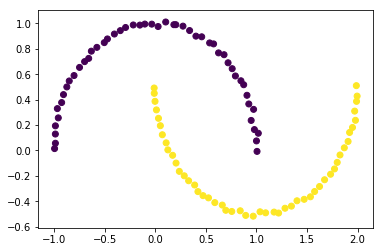

In [2]:
data, target = datasets.make_moons(noise=0.01)
plt.scatter(data[:,0],data[:,1],c=target)
plt.show()

### 二.核技巧
核技巧简单来说分为两步：  
（1）将低维非线性可分数据$x$，通过一个非线性映射函数$\phi$，映射到一个新空间（高维度甚至是无限维空间）；  
（2）对新空间的数据$\phi(x)$训练线性分类器  

比如如下的情况：  

原始数据需要使用一个椭圆才能分隔开，但对原始数据施加一个非线性变换$\phi:(x_1,x_2)->(x_1^2,x_2^2)$变换后，在新空间中就可以线性分隔了

![avatar](./source/06_核技巧.svg) 

#### 利用核技巧后的SVM
所以，如果对原始数据施加一个映射，此时软间隔SVM的对偶问题为：  

$$
\min_{\alpha} \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N\alpha_i\alpha_jy_iy_j\phi(x_i)^T\phi(x_j)-\sum_{i=1}^N\alpha_i\\
s.t.\sum_{i=1}^N\alpha_iy_i=0,\\
0\leq\alpha_i\leq C,i=1,2,...,N
$$  
求解得最优$\alpha_i^*$后，SVM模型为：  

$$
f(x)=sign(\sum_{i=1}^N\alpha_iy_i\phi(x_i)^T\phi(x)+b^*)
$$

### 三.核函数   
观察一下上面公式，我们的目的其实是求解$\phi(x_i)^T\phi(x_j)$，有没有一种函数让$(x_i,x_j)$只在原始空间做计算就达到$\phi(x_i)^T\phi(x_j)$的效果呢？有的，那就是核函数，即：  

$$
K(x_i,x_j)=\phi(x_i)^T\phi(x_j)
$$  

#### 怎样的函数才能做核函数？
要成为核函数必须满足如下两点条件：  

（1）对称性：$K(x_i,x_j)=K(x_j,x_i)$  

（2）正定性：对任意的$x_i,i=1,2,..,m$，$K(x,z)$对应的Gramm矩阵：  

$$
K=[K(x_i,x_j)]_{m\times m}
$$  
是半正定矩阵，这里的$x_i\in$可行域，并不要求一定要属于样本集  

#### 常见的核函数有哪些？

目前用的比较多的核函数有如下一些：  

（1）多项式核函数：  

$$
K(x,z)=(x^Tz+1)^p
$$  

（2）高斯核函数：  

$$
K(x,z)=exp(-\frac{\mid\mid x-z\mid\mid^2}{2\sigma^2})
$$  

显然，线性可分SVM中使用的是$K(x,z)=x^Tz$也是核函数

#### 利用核函数后的SVM

利用核函数后，软间隔SVM的对偶问题为：  

$$
\min_{\alpha} \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N\alpha_i\alpha_jy_iy_jK(x_i,x_j)-\sum_{i=1}^N\alpha_i\\
s.t.\sum_{i=1}^N\alpha_iy_i=0,\\
0\leq\alpha_i\leq C,i=1,2,...,N
$$  
求解得最优$\alpha_i^*$后，SVM模型为：  

$$
f(x)=sign(\sum_{i=1}^N\alpha_iy_iK(x,x_i)+b^*)
$$

### 四.代码实现
代码实现很简单，就在软间隔SVM的基础上将向量的内积计算$x^Tz$替换为$K(x,z)$即可，首先定义一些核函数：  

In [3]:
"""
该部分放到ml_model.kernel_functions中
"""

def linear():
    """
    线性核函数
    :return:linear function
    """

    def _linear(x, y):
        return np.dot(x, y)

    return _linear


def poly(p=2):
    """
    多项式核函数
    :param p:
    :return: poly function
    """

    def _poly(x, y):
        return np.power(np.dot(x, y) + 1, p)

    return _poly


def rbf(sigma=0.1):
    """
    径向基/高斯核函数
    :param sigma:
    :return:
    """

    def _rbf(x, y):
        np_x = np.asarray(x)
        if np_x.ndim <= 1:
            return np.exp((-1 * np.dot(x - y, x - y) / (2 * sigma * sigma)))
        else:
            return np.exp((-1 * np.multiply(x - y, x - y).sum(axis=1) / (2 * sigma * sigma)))

    return _rbf

In [4]:
from ml_models import kernel_functions


class SVC(object):
    def __init__(self, epochs=100, C=1.0, tol=1e-3, kernel=None, degree=3, gamma=0.1):
        """
        :param epochs: 迭代次数上限
        :param C: C越小，对于误分类的惩罚越小
        :param tol:提前中止训练时的误差值上限，避免迭代太久
        :param kernel:核函数
        :param degree:kernel='poly'时生效
        :param gamma:kernel='rbf'时生效
        """
        self.b = None
        self.alpha = None
        self.E = None
        self.epochs = epochs
        self.C = C
        self.tol = tol
        # 定义核函数
        if kernel is None:
            self.kernel_function = kernel_functions.linear()
        elif kernel == 'poly':
            self.kernel_function = kernel_functions.poly(degree)
        elif kernel == 'rbf':
            self.kernel_function = kernel_functions.rbf(gamma)
        else:
            self.kernel_function = kernel_functions.linear()
        # 记录支持向量
        self.support_vectors = None
        # 记录支持向量的x
        self.support_vector_x = []
        # 记录支持向量的y
        self.support_vector_y = []
        # 记录支持向量的alpha
        self.support_vector_alpha = []

    def f(self, x):
        """
        :param x:
        :return: wx+b
        """
        x_np = np.asarray(x)
        if len(self.support_vector_x) == 0:
            if x_np.ndim <= 1:
                return 0
            else:
                return np.zeros((x_np.shape[:-1]))
        else:
            if x_np.ndim <= 1:
                wx = 0
            else:
                wx = np.zeros((x_np.shape[:-1]))
            for i in range(0, len(self.support_vector_x)):
                wx += self.kernel_function(x, self.support_vector_x[i]) * self.support_vector_alpha[i] * \
                      self.support_vector_y[i]
            return wx + self.b

    def init_params(self, X, y):
        """
        :param X: (n_samples,n_features)
        :param y: (n_samples,) y_i\in\{0,1\}
        :return:
        """
        n_samples, n_features = X.shape
        self.b = .0
        self.alpha = np.zeros(n_samples)
        self.E = np.zeros(n_samples)
        # 初始化E
        for i in range(0, n_samples):
            self.E[i] = self.f(X[i, :]) - y[i]

    def _select_j(self, best_i):
        """
        选择j
        :param best_i:
        :return:
        """
        valid_j_list = [i for i in range(0, len(self.alpha)) if self.alpha[i] > 0 and i != best_i]
        best_j = -1
        # 优先选择使得|E_i-E_j|最大的j
        if len(valid_j_list) > 0:
            max_e = 0
            for j in valid_j_list:
                current_e = np.abs(self.E[best_i] - self.E[j])
                if current_e > max_e:
                    best_j = j
                    max_e = current_e
        else:
            # 随机选择
            l = list(range(len(self.alpha)))
            seq = l[: best_i] + l[best_i + 1:]
            best_j = random.choice(seq)
        return best_j

    def _meet_kkt(self, x_i, y_i, alpha_i):
        """
        判断是否满足KKT条件

        :param w:
        :param b:
        :param x_i:
        :param y_i:
        :return:
        """
        if alpha_i < self.C:
            return y_i * self.f(x_i) >= 1 - self.tol
        else:
            return y_i * self.f(x_i) <= 1 + self.tol

    def fit(self, X, y2, show_train_process=False):
        """

        :param X:
        :param y2:
        :param show_train_process: 显示训练过程
        :return:
        """
        y = copy.deepcopy(y2)
        y[y == 0] = -1
        # 初始化参数
        self.init_params(X, y)
        for _ in range(0, self.epochs):
            if_all_match_kkt = True
            for i in range(0, len(self.alpha)):
                x_i = X[i, :]
                y_i = y[i]
                alpha_i_old = self.alpha[i]
                E_i_old = self.E[i]
                # 外层循环：选择违反KKT条件的点i
                if not self._meet_kkt(x_i, y_i, alpha_i_old):
                    if_all_match_kkt = False
                    # 内层循环，选择使|Ei-Ej|最大的点j
                    best_j = self._select_j(i)

                    alpha_j_old = self.alpha[best_j]
                    x_j = X[best_j, :]
                    y_j = y[best_j]
                    E_j_old = self.E[best_j]

                    # 进行更新
                    # 1.首先获取无裁剪的最优alpha_2
                    eta = self.kernel_function(x_i, x_i) + self.kernel_function(x_j, x_j) - 2.0 * self.kernel_function(
                        x_i, x_j)
                    # 如果x_i和x_j很接近，则跳过
                    if eta < 1e-3:
                        continue
                    alpha_j_unc = alpha_j_old + y_j * (E_i_old - E_j_old) / eta
                    # 2.裁剪并得到new alpha_2
                    if y_i == y_j:
                        L = max(0., alpha_i_old + alpha_j_old - self.C)
                        H = min(self.C, alpha_i_old + alpha_j_old)
                    else:
                        L = max(0, alpha_j_old - alpha_i_old)
                        H = min(self.C, self.C + alpha_j_old - alpha_i_old)

                    if alpha_j_unc < L:
                        alpha_j_new = L
                    elif alpha_j_unc > H:
                        alpha_j_new = H
                    else:
                        alpha_j_new = alpha_j_unc

                    # 如果变化不够大则跳过
                    if np.abs(alpha_j_new - alpha_j_old) < 1e-5:
                        continue
                    # 3.得到alpha_1_new
                    alpha_i_new = alpha_i_old + y_i * y_j * (alpha_j_old - alpha_j_new)
                    # 5.更新alpha_1,alpha_2
                    self.alpha[i] = alpha_i_new
                    self.alpha[best_j] = alpha_j_new
                    # 6.更新b
                    b_i_new = y_i - self.f(x_i) + self.b
                    b_j_new = y_j - self.f(x_j) + self.b
                    if self.C > alpha_i_new > 0:
                        self.b = b_i_new
                    elif self.C > alpha_j_new > 0:
                        self.b = b_j_new
                    else:
                        self.b = (b_i_new + b_j_new) / 2.0
                    # 7.更新E
                    for k in range(0, len(self.E)):
                        self.E[k] = self.f(X[k, :]) - y[k]

                    # 8.更新支持向量相关的信息
                    self.support_vectors = np.where(self.alpha > 1e-3)[0]
                    self.support_vector_x = [X[i, :] for i in self.support_vectors]
                    self.support_vector_y = [y[i] for i in self.support_vectors]
                    self.support_vector_alpha = [self.alpha[i] for i in self.support_vectors]

                    # 显示训练过程
                    if show_train_process is True:
                        utils.plot_decision_function(X, y2, self, [i, best_j])
                        utils.plt.pause(0.1)
                        utils.plt.clf()

            # 如果所有的点都满足KKT条件，则中止
            if if_all_match_kkt is True:
                break

        # 显示最终结果
        if show_train_process is True:
            utils.plot_decision_function(X, y2, self, self.support_vectors)
            utils.plt.show()

    def get_params(self):
        """
        输出原始的系数
        :return: w
        """

        return self.w, self.b

    def predict_proba(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        return utils.sigmoid(self.f(x))

    def predict(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        proba = self.predict_proba(x)
        return (proba >= 0.5).astype(int)

### 五.查看效果

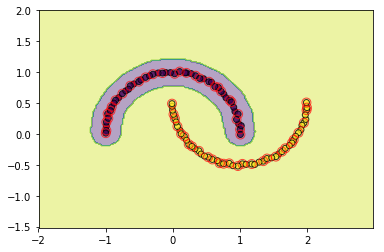

In [5]:
#查看rbf的效果
svm = SVC(C=3.0, kernel='rbf',gamma=0.1, epochs=10, tol=0.2)
svm.fit(data, target)
utils.plot_decision_function(data, target, svm, svm.support_vectors)

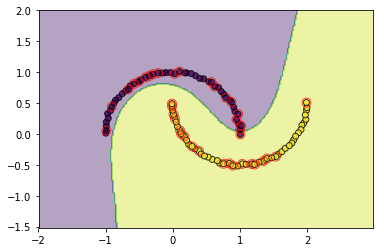

In [6]:
#查看poly的效果
svm = SVC(C=3.0, kernel='poly',degree=3, epochs=10, tol=0.2)
svm.fit(data, target)
utils.plot_decision_function(data, target, svm, svm.support_vectors)

### 六.问题讨论

#### 1.RBF函数中$\sigma$的不同取值对训练的影响
为了探索该问题，我们对$\sigma$从小到大取一组数，在另外一个伪数据上查看效果

In [7]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

In [8]:
c1 = SVC(C=3.0, kernel='rbf',gamma=0.1, epochs=10, tol=0.01)
c1.fit(data, target)
c2 = SVC(C=3.0, kernel='rbf',gamma=0.5, epochs=10, tol=0.01)
c2.fit(data, target)
c3 = SVC(C=3.0, kernel='rbf',gamma=2, epochs=10, tol=0.01)
c3.fit(data, target)

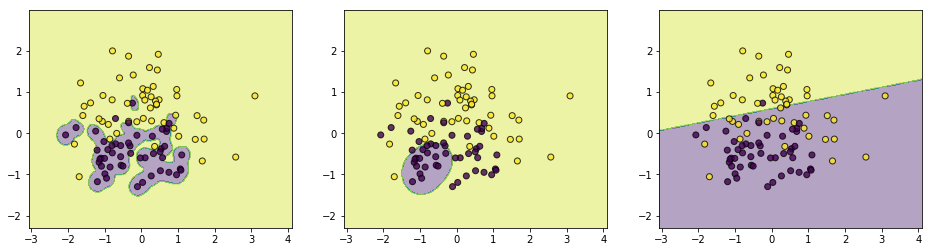

In [9]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
utils.plot_decision_function(data,target,c1)
plt.subplot(1,3,2)
utils.plot_decision_function(data,target,c2)
plt.subplot(1,3,3)
utils.plot_decision_function(data,target,c3)

上面$\sigma$分别取值$[0.1,0.5,2]$，通过结果可以简单总结如下：   

（1）如果$\sigma$取值越小，SVM越能抓住个别样本的信息，越容易过拟合；   

（2）$\sigma$取值越大SVM的泛化能力越强  

如何对该结果进行理解呢？可以通过样本点在映射空间的距离来看，对任意两个样本点$x,z$，它们在映射空间中的距离的平方可以表示如下：      

$$
||\phi(x)-\phi(z)||^2=(\phi(x)-\phi(z))^T(\phi(x)-\phi(z))\\
=\phi(x)^T\phi(x)+\phi(z)^T\phi(z)-2\phi(x)^T\phi(z)\\
=K(x,x)+K(z,z)-2K(x,z)\\
=2-2\cdot exp(-\frac{\mid\mid x-z\mid\mid^2}{2\sigma^2})（将K(x,z)替换为RBF函数）
$$   

所以：   

（1）如果$\sigma\rightarrow 0$，那么$-\frac{\mid\mid x-z\mid\mid^2}{2\sigma^2}\rightarrow -\infty$，那么$exp(-\frac{\mid\mid x-z\mid\mid^2}{2\sigma^2})\rightarrow 0$，那么$||\phi(x)-\phi(z)||\rightarrow \sqrt 2$   

（2）如果$\sigma\rightarrow \infty$，那么$-\frac{\mid\mid x-z\mid\mid^2}{2\sigma^2}\rightarrow 0$，那么$exp(-\frac{\mid\mid x-z\mid\mid^2}{2\sigma^2})\rightarrow 1$，那么$||\phi(x)-\phi(z)||\rightarrow 0$   

我们可以验证上面的总结，若$\sigma$取值越小，样本点在映射空间越分散，则在高维空间越容易线性可分，表现在低维空间则越容易过拟合；$\sigma$取值越大，样本点在映射空间越集中，越不易线性可分，表现在低维空间也是不易线性可分  

#### 2.如何理解RBF可将数据映射到无限维空间
原谅自己，这部分公式不想码了，具体内容参考大神的[知乎帖子>>>](https://zhuanlan.zhihu.com/p/58585604)，其中主要需要用到两个等式变换：   

（1）指数函数的泰勒级数：$e^x=\sum_{n=1}^{\infty}\frac{x^n}{n!}$，将RBF函数进行展开；   

（2）利用多项式展开定理，将样本$x$与$z$在原始空间的内积的$n$次方进行展开，假如$x,z\in R^k$，那么：   
$$
(x^Tz)^n=(\sum_{i=1}^kx_iz_i)^n\\
=\sum_{l=1}^L\frac{n!}{n_{l_1}!n_{l_2}!\cdots n_{l_k}!}(x_1z_1)^{n_{l_1}}(x_2z_2)^{n_{l_2}}\cdots (x_kz_k)^{n_{l_k}}
$$   

这里，$\sum_{i=1}^kn_{l_i}=n$，$L=\frac{(n+k-1)!}{n!(k-1)!}$，进一步的，上面等式可以化简为形如这样的表达式：$\Phi(x)^T\Phi(z)$，$\Phi(x)=[\Phi_1(x),\Phi_2(x),\cdots ,\Phi_L(x)]$